In [78]:
import tensorflow as tf
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, LSTM, Dense, Flatten, Conv1D, GRU
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

In [24]:
df = pd.read_csv('../data/forecast/climate.csv')

In [25]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [26]:
df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')

In [27]:
# интервал 1ч
df = df[5::6]

In [28]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,,
2009-01-01 01:00:00,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


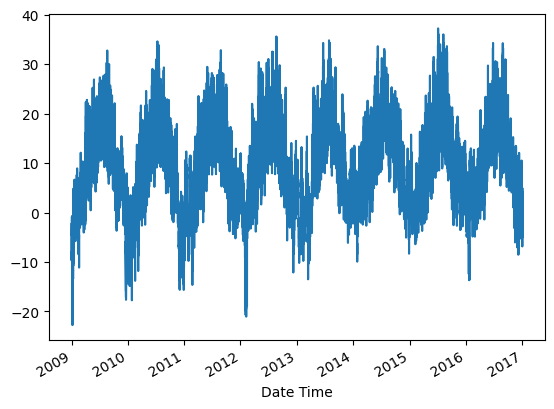

In [29]:
temp = df['T (degC)']
temp.plot();

In [30]:
temp.shape

(70091,)

In [31]:
temp.head()

Date Time
2009-01-01 01:00:00   -8.05
2009-01-01 02:00:00   -8.88
2009-01-01 03:00:00   -8.81
2009-01-01 04:00:00   -9.05
2009-01-01 05:00:00   -9.63
Name: T (degC), dtype: float64

In [32]:
# [[[1], [2], [3], [4], [5]]] window (X), predict at [6] oclock (y)
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i:i+5]]
        X.append(row)
        label = df_as_np[i+5]
        y.append(label)
    
    return np.array(X), np.array(y)

In [34]:
X, y = df_to_X_y(temp)
X.shape, y.shape

((70086, 5, 1), (70086,))

In [35]:
X_train, y_train = X[:60000], y[:60000]
X_val, y_val = X[60000:65000], y[60000:65000]
X_test, y_test = X[65000:], y[65000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((60000, 5, 1), (60000,), (5000, 5, 1), (5000,), (5086, 5, 1), (5086,))

<h3>LSTM</h3>

In [74]:
model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                16896     
                                                                 
 dense_6 (Dense)             (None, 8)                 520       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [46]:
cp = ModelCheckpoint('../models/temp/', seve_best_only=True)

In [47]:
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [48]:
history = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp])

Epoch 1/10
1866/1875 [============================>.] - ETA: 0s - loss: 28.4196 - root_mean_squared_error: 5.3310

INFO:tensorflow:Assets written to: ../models/temp\assets


INFO:tensorflow:Assets written to: ../models/temp\assets


1875/1875 [==============================] - 9s 4ms/step - loss: 28.3067 - root_mean_squared_error: 5.3204 - val_loss: 2.1534 - val_root_mean_squared_error: 1.4675
Epoch 2/10
1865/1875 [============================>.] - ETA: 0s - loss: 5.1977 - root_mean_squared_error: 2.2798

INFO:tensorflow:Assets written to: ../models/temp\assets


INFO:tensorflow:Assets written to: ../models/temp\assets


1875/1875 [==============================] - 7s 4ms/step - loss: 5.1977 - root_mean_squared_error: 2.2798 - val_loss: 1.8939 - val_root_mean_squared_error: 1.3762
Epoch 3/10
1870/1875 [============================>.] - ETA: 0s - loss: 2.4604 - root_mean_squared_error: 1.5686

INFO:tensorflow:Assets written to: ../models/temp\assets


INFO:tensorflow:Assets written to: ../models/temp\assets


1875/1875 [==============================] - 8s 4ms/step - loss: 2.4560 - root_mean_squared_error: 1.5672 - val_loss: 0.5990 - val_root_mean_squared_error: 0.7739
Epoch 4/10
1875/1875 [==============================] - ETA: 0s - loss: 0.8985 - root_mean_squared_error: 0.9479

INFO:tensorflow:Assets written to: ../models/temp\assets


INFO:tensorflow:Assets written to: ../models/temp\assets


1875/1875 [==============================] - 7s 4ms/step - loss: 0.8985 - root_mean_squared_error: 0.9479 - val_loss: 0.5227 - val_root_mean_squared_error: 0.7230
Epoch 5/10
1869/1875 [============================>.] - ETA: 0s - loss: 0.7363 - root_mean_squared_error: 0.8581

INFO:tensorflow:Assets written to: ../models/temp\assets


INFO:tensorflow:Assets written to: ../models/temp\assets


1875/1875 [==============================] - 8s 4ms/step - loss: 0.7367 - root_mean_squared_error: 0.8583 - val_loss: 0.5291 - val_root_mean_squared_error: 0.7274
Epoch 6/10
1870/1875 [============================>.] - ETA: 0s - loss: 0.6929 - root_mean_squared_error: 0.8324

INFO:tensorflow:Assets written to: ../models/temp\assets


INFO:tensorflow:Assets written to: ../models/temp\assets


1875/1875 [==============================] - 7s 4ms/step - loss: 0.6927 - root_mean_squared_error: 0.8323 - val_loss: 0.5093 - val_root_mean_squared_error: 0.7136
Epoch 7/10
1859/1875 [============================>.] - ETA: 0s - loss: 0.6759 - root_mean_squared_error: 0.8221

INFO:tensorflow:Assets written to: ../models/temp\assets


INFO:tensorflow:Assets written to: ../models/temp\assets


1875/1875 [==============================] - 7s 4ms/step - loss: 0.6749 - root_mean_squared_error: 0.8215 - val_loss: 0.4954 - val_root_mean_squared_error: 0.7039
Epoch 8/10
1866/1875 [============================>.] - ETA: 0s - loss: 0.6647 - root_mean_squared_error: 0.8153

INFO:tensorflow:Assets written to: ../models/temp\assets


INFO:tensorflow:Assets written to: ../models/temp\assets


1875/1875 [==============================] - 7s 4ms/step - loss: 0.6652 - root_mean_squared_error: 0.8156 - val_loss: 0.5051 - val_root_mean_squared_error: 0.7107
Epoch 9/10
1859/1875 [============================>.] - ETA: 0s - loss: 0.6597 - root_mean_squared_error: 0.8122

INFO:tensorflow:Assets written to: ../models/temp\assets


INFO:tensorflow:Assets written to: ../models/temp\assets


1875/1875 [==============================] - 8s 4ms/step - loss: 0.6601 - root_mean_squared_error: 0.8124 - val_loss: 0.4966 - val_root_mean_squared_error: 0.7047
Epoch 10/10
1875/1875 [==============================] - ETA: 0s - loss: 0.6550 - root_mean_squared_error: 0.8093

INFO:tensorflow:Assets written to: ../models/temp\assets


INFO:tensorflow:Assets written to: ../models/temp\assets


1875/1875 [==============================] - 8s 4ms/step - loss: 0.6550 - root_mean_squared_error: 0.8093 - val_loss: 0.4904 - val_root_mean_squared_error: 0.7003


In [50]:
model1 = load_model('../models/temp/')

In [56]:
train_predictions = model1.predict(X_test).flatten()
train_results = pd.DataFrame(data={'Predictions': train_predictions, 'Actual': y_test})

159/159 [==============================] - 0s 2ms/step


In [57]:
train_results

,Predictions,Actual
0,14.459113,13.99
1,13.305625,13.46
2,12.932778,12.93
3,12.520816,12.43
4,12.064219,12.17
...,...,...
5081,-0.991189,-0.98
5082,-1.447686,-1.40
5083,-1.724226,-2.75
5084,-3.453066,-2.89


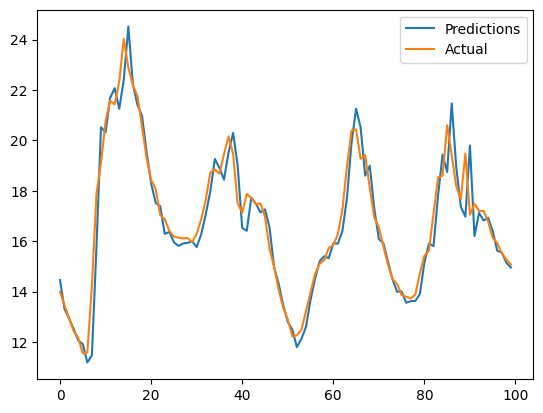

In [62]:
plt.plot(train_results['Predictions'][:100], label='Predictions')
plt.plot(train_results['Actual'][:100], label='Actual')
plt.legend();

<h3>CNN</h3>

In [75]:
model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(Conv1D(64, kernel_size=2))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 4, 64)             192       
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 8)                 2056      
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


In [76]:
cp2 = ModelCheckpoint('../models/temp2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [77]:
history2 = model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp2])

Epoch 1/10
1856/1875 [============================>.] - ETA: 0s - loss: 8.4742 - root_mean_squared_error: 2.9110

INFO:tensorflow:Assets written to: ../models/temp2\assets


INFO:tensorflow:Assets written to: ../models/temp2\assets


1875/1875 [==============================] - 5s 2ms/step - loss: 8.4007 - root_mean_squared_error: 2.8984 - val_loss: 0.9580 - val_root_mean_squared_error: 0.9788
Epoch 2/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.9979 - root_mean_squared_error: 0.9990

INFO:tensorflow:Assets written to: ../models/temp2\assets


INFO:tensorflow:Assets written to: ../models/temp2\assets


1875/1875 [==============================] - 3s 2ms/step - loss: 0.9978 - root_mean_squared_error: 0.9989 - val_loss: 0.6189 - val_root_mean_squared_error: 0.7867
Epoch 3/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.7467 - root_mean_squared_error: 0.8641

INFO:tensorflow:Assets written to: ../models/temp2\assets


INFO:tensorflow:Assets written to: ../models/temp2\assets


1875/1875 [==============================] - 4s 2ms/step - loss: 0.7465 - root_mean_squared_error: 0.8640 - val_loss: 0.5320 - val_root_mean_squared_error: 0.7294
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6964 - root_mean_squared_error: 0.8345 - val_loss: 0.5403 - val_root_mean_squared_error: 0.7351
Epoch 5/10
1854/1875 [============================>.] - ETA: 0s - loss: 0.6806 - root_mean_squared_error: 0.8250

INFO:tensorflow:Assets written to: ../models/temp2\assets


INFO:tensorflow:Assets written to: ../models/temp2\assets


1875/1875 [==============================] - 3s 2ms/step - loss: 0.6797 - root_mean_squared_error: 0.8244 - val_loss: 0.5011 - val_root_mean_squared_error: 0.7079
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6713 - root_mean_squared_error: 0.8193 - val_loss: 0.5075 - val_root_mean_squared_error: 0.7124
Epoch 7/10
1854/1875 [============================>.] - ETA: 0s - loss: 0.6682 - root_mean_squared_error: 0.8174

INFO:tensorflow:Assets written to: ../models/temp2\assets


INFO:tensorflow:Assets written to: ../models/temp2\assets


1875/1875 [==============================] - 3s 2ms/step - loss: 0.6690 - root_mean_squared_error: 0.8179 - val_loss: 0.4957 - val_root_mean_squared_error: 0.7041
Epoch 8/10
1845/1875 [============================>.] - ETA: 0s - loss: 0.6656 - root_mean_squared_error: 0.8158

INFO:tensorflow:Assets written to: ../models/temp2\assets


INFO:tensorflow:Assets written to: ../models/temp2\assets


1875/1875 [==============================] - 3s 2ms/step - loss: 0.6642 - root_mean_squared_error: 0.8150 - val_loss: 0.4928 - val_root_mean_squared_error: 0.7020
Epoch 9/10
1864/1875 [============================>.] - ETA: 0s - loss: 0.6631 - root_mean_squared_error: 0.8143

INFO:tensorflow:Assets written to: ../models/temp2\assets


INFO:tensorflow:Assets written to: ../models/temp2\assets


1875/1875 [==============================] - 3s 2ms/step - loss: 0.6630 - root_mean_squared_error: 0.8142 - val_loss: 0.4883 - val_root_mean_squared_error: 0.6988
Epoch 10/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6618 - root_mean_squared_error: 0.8135 - val_loss: 0.5091 - val_root_mean_squared_error: 0.7135


<h3>GRU</h3>

In [80]:
model3 = Sequential()
model3.add(InputLayer((5, 1)))
model3.add(GRU(64))
model3.add(Flatten())
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))

model3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 64)                12864     
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 8)                 520       
                                                                 
 dense_13 (Dense)            (None, 1)                 9         
                                                                 
Total params: 13,393
Trainable params: 13,393
Non-trainable params: 0
_________________________________________________________________


In [81]:
cp3 = ModelCheckpoint('../models/temp3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [82]:
history3 = model3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp3])

Epoch 1/10
1869/1875 [============================>.] - ETA: 0s - loss: 31.1707 - root_mean_squared_error: 5.5831

INFO:tensorflow:Assets written to: ../models/temp3\assets


INFO:tensorflow:Assets written to: ../models/temp3\assets


1875/1875 [==============================] - 11s 5ms/step - loss: 31.0823 - root_mean_squared_error: 5.5752 - val_loss: 1.0672 - val_root_mean_squared_error: 1.0331
Epoch 2/10
1870/1875 [============================>.] - ETA: 0s - loss: 1.9374 - root_mean_squared_error: 1.3919

INFO:tensorflow:Assets written to: ../models/temp3\assets


INFO:tensorflow:Assets written to: ../models/temp3\assets


1875/1875 [==============================] - 9s 5ms/step - loss: 1.9340 - root_mean_squared_error: 1.3907 - val_loss: 0.6149 - val_root_mean_squared_error: 0.7842
Epoch 3/10
1866/1875 [============================>.] - ETA: 0s - loss: 0.8976 - root_mean_squared_error: 0.9474

INFO:tensorflow:Assets written to: ../models/temp3\assets


INFO:tensorflow:Assets written to: ../models/temp3\assets


1875/1875 [==============================] - 9s 5ms/step - loss: 0.8959 - root_mean_squared_error: 0.9465 - val_loss: 0.5298 - val_root_mean_squared_error: 0.7279
Epoch 4/10
1875/1875 [==============================] - ETA: 0s - loss: 0.7111 - root_mean_squared_error: 0.8433

INFO:tensorflow:Assets written to: ../models/temp3\assets


INFO:tensorflow:Assets written to: ../models/temp3\assets


1875/1875 [==============================] - 9s 5ms/step - loss: 0.7111 - root_mean_squared_error: 0.8433 - val_loss: 0.5238 - val_root_mean_squared_error: 0.7237
Epoch 5/10
1865/1875 [============================>.] - ETA: 0s - loss: 0.6660 - root_mean_squared_error: 0.8161

INFO:tensorflow:Assets written to: ../models/temp3\assets


INFO:tensorflow:Assets written to: ../models/temp3\assets


1875/1875 [==============================] - 9s 5ms/step - loss: 0.6660 - root_mean_squared_error: 0.8161 - val_loss: 0.5174 - val_root_mean_squared_error: 0.7193
Epoch 6/10
1865/1875 [============================>.] - ETA: 0s - loss: 0.6525 - root_mean_squared_error: 0.8078

INFO:tensorflow:Assets written to: ../models/temp3\assets


INFO:tensorflow:Assets written to: ../models/temp3\assets


1875/1875 [==============================] - 8s 4ms/step - loss: 0.6520 - root_mean_squared_error: 0.8075 - val_loss: 0.4989 - val_root_mean_squared_error: 0.7063
Epoch 7/10
1865/1875 [============================>.] - ETA: 0s - loss: 0.6486 - root_mean_squared_error: 0.8053

INFO:tensorflow:Assets written to: ../models/temp3\assets


INFO:tensorflow:Assets written to: ../models/temp3\assets


1875/1875 [==============================] - 8s 4ms/step - loss: 0.6482 - root_mean_squared_error: 0.8051 - val_loss: 0.4884 - val_root_mean_squared_error: 0.6988
Epoch 8/10
1866/1875 [============================>.] - ETA: 0s - loss: 0.6428 - root_mean_squared_error: 0.8018

INFO:tensorflow:Assets written to: ../models/temp3\assets


INFO:tensorflow:Assets written to: ../models/temp3\assets


1875/1875 [==============================] - 8s 4ms/step - loss: 0.6429 - root_mean_squared_error: 0.8018 - val_loss: 0.4873 - val_root_mean_squared_error: 0.6981
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6418 - root_mean_squared_error: 0.8011 - val_loss: 0.4903 - val_root_mean_squared_error: 0.7002
Epoch 10/10
1871/1875 [============================>.] - ETA: 0s - loss: 0.6397 - root_mean_squared_error: 0.7998

INFO:tensorflow:Assets written to: ../models/temp3\assets


INFO:tensorflow:Assets written to: ../models/temp3\assets


1875/1875 [==============================] - 8s 4ms/step - loss: 0.6394 - root_mean_squared_error: 0.7996 - val_loss: 0.4867 - val_root_mean_squared_error: 0.6977
